In [1]:
library(Seurat)
library(Signac)
library(CellChat)
library(patchwork)
library(argparse)
source("/tscc/projects/ps-epigen/users/kdang/eye_final/source_FunFig.R")
library(dplyr)                                                               
library(devtools)
library(hdf5r)
source("/tscc/projects/ps-epigen/bpToolbox/utils.R")
source("/tscc/nfs/home/a2jorgensen/toolbox/BpdToolbox/qc_report.R")
library(reshape2)
library(Nebulosa)
library(stringr)
library(harmony)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

Loading required package: usethis

Warning message:
“package ‘hdf5r’ was built under R version 4.4.2”
Loading required package: Rcpp



In [2]:
setwd("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/rds_objs/")

In [3]:
sobj <- readRDS("JB_1466_w_demux_data.RDS")

In [4]:
dir.create("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Clustering/JB_1466/")

Warning message in dir.create("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Clustering/JB_1466/"):
“'/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Clustering/JB_1466' already exists”


In [5]:
setwd("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Clustering/JB_1466/")

In [6]:
demux_lib3 <- read.table("/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Demux/250317_AT2_organoid_ZO/popscle_out/JB_1466_1_2.best", header = TRUE, sep = "\t", stringsAsFactors = FALSE)
rownames(demux_lib3) <- demux_lib3$BARCODE
# Extract barcodes from Seurat object
seurat_barcodes <- rownames(sobj@meta.data)

# Extract barcodes from Demuxlet table
demux_barcodes <- rownames(demux_lib3)


In [7]:
# Find barcodes in Demuxlet but not in Seurat
demux_not_in_seurat <- setdiff(demux_barcodes, seurat_barcodes)

# Find barcodes in Seurat but not in Demuxlet
seurat_not_in_demux <- setdiff(seurat_barcodes, demux_barcodes)

# Print differences
cat("Barcodes in Demuxlet but not in Seurat:\n")
print(head(demux_not_in_seurat, 10))  # Show first 10

cat("Barcodes in Seurat but not in Demuxlet:\n")
print(head(seurat_not_in_demux, 10))  # Show first 10

# Count differences
cat("Number of barcodes in Demuxlet but not in Seurat:", length(demux_not_in_seurat), "\n")
cat("Number of barcodes in Seurat but not in Demuxlet:", length(seurat_not_in_demux), "\n")

Barcodes in Demuxlet but not in Seurat:
 [1] "."                  "AAACCAAAGAAGCTAA-1" "AAACCAAAGCATCAAT-1"
 [4] "AAACCAAAGCATCTCT-1" "AAACCAAAGCCACAGT-1" "AAACCAAAGCCGCATG-1"
 [7] "AAACCAAAGCTAGTAT-1" "AAACCAAAGGAATGAC-1" "AAACCAAAGGAGCTTC-1"
[10] "AAACCAAAGGGTACGA-1"
Barcodes in Seurat but not in Demuxlet:
 [1] "AAACGGGTCTAAGCAT-1" "ACAGCGAAGGTCATCA-1" "ACATGAGGTAGGCGAT-1"
 [4] "ACCACAATCGTGCCAG-1" "CAAGGAACAAATTCCT-1" "CAAGTTTAGCCACGAT-1"
 [7] "CACGGTTAGCAAGGGC-1" "CAGCATATCACATACG-1" "CCGACTAGTAAGCAGC-1"
[10] "CGTCAGTAGGAGGCTA-1"
Number of barcodes in Demuxlet but not in Seurat: 33743 
Number of barcodes in Seurat but not in Demuxlet: 22 


In [8]:
sobj

An object of class Seurat 
44696 features across 16578 samples within 2 assays 
Active assay: SCT (21631 features, 5000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap.rna

In [9]:
# Keep only rows where barcodes match Seurat object
demux_lib3_subset <- demux_lib3[demux_barcodes %in% seurat_barcodes, , drop = FALSE]
# Verify barcode alignment
cat("Final number of matching barcodes:", nrow(demux_lib3_subset), "\n")

Final number of matching barcodes: 16556 


In [11]:
barcodes<- rownames(demux_lib3_subset)
length(barcodes)
sobj_subset <- subset(sobj, cells = barcodes)

[1] 16556

In [12]:
sobj_subset

An object of class Seurat 
44696 features across 16556 samples within 2 assays 
Active assay: SCT (21631 features, 5000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap.rna

In [13]:
unique(is.na(sobj_subset$DROPLET.TYPE))

[1] FALSE

In [14]:
sobj<- sobj_subset

In [15]:
sobj <- RunHarmony(sobj, reduction = "pca", group.by.vars = "SNG.BEST.GUESS", 
               assay.use = DefaultAssay(sobj),
               reduction.save = "harm.pca")

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



In [20]:
print("Find neighbors")
sobj <- FindNeighbors(sobj, reduction = "harm.pca", dims = 1:50) #reduction = red_nm_rna not working
sobj <- FindClusters(sobj, resolution = 1.0, verbose = F)
print("Run UMAP")
sobj <- RunUMAP(sobj, dims = 1:50, reduction = "harm.pca", 
                reduction.name =  "harm.pca.umap" ,  verbose = F)
print(Sys.time())

[1] "Find neighbors"


Computing nearest neighbor graph

Computing SNN



[1] "Run UMAP"
[1] "2025-04-07 15:17:55 PDT"


In [21]:
colors <- c("#72ACEC", "#05A4CF", "#477BC1", "#196BEF", "#0B3B7B", "#0AD0D0", "#677DED",  
                              "#F15237", "coral", "#E7C65B", "goldenrod", "#AC6906", "olivedrab", "olivedrab2",  
                              "mediumseagreen", "#73C977", "#8B6CC4", "#D9B3FF", "#E65ADF", "#A111A5",  
                              "#FDC1FD", "gray",  
                              "#4682B4", "#1E90FF", "#00CED1", "#32CD32", "#FFD700", "#FF8C00", "#DC143C",  
                              "#8B0000", "#556B2F", "#9932CC")

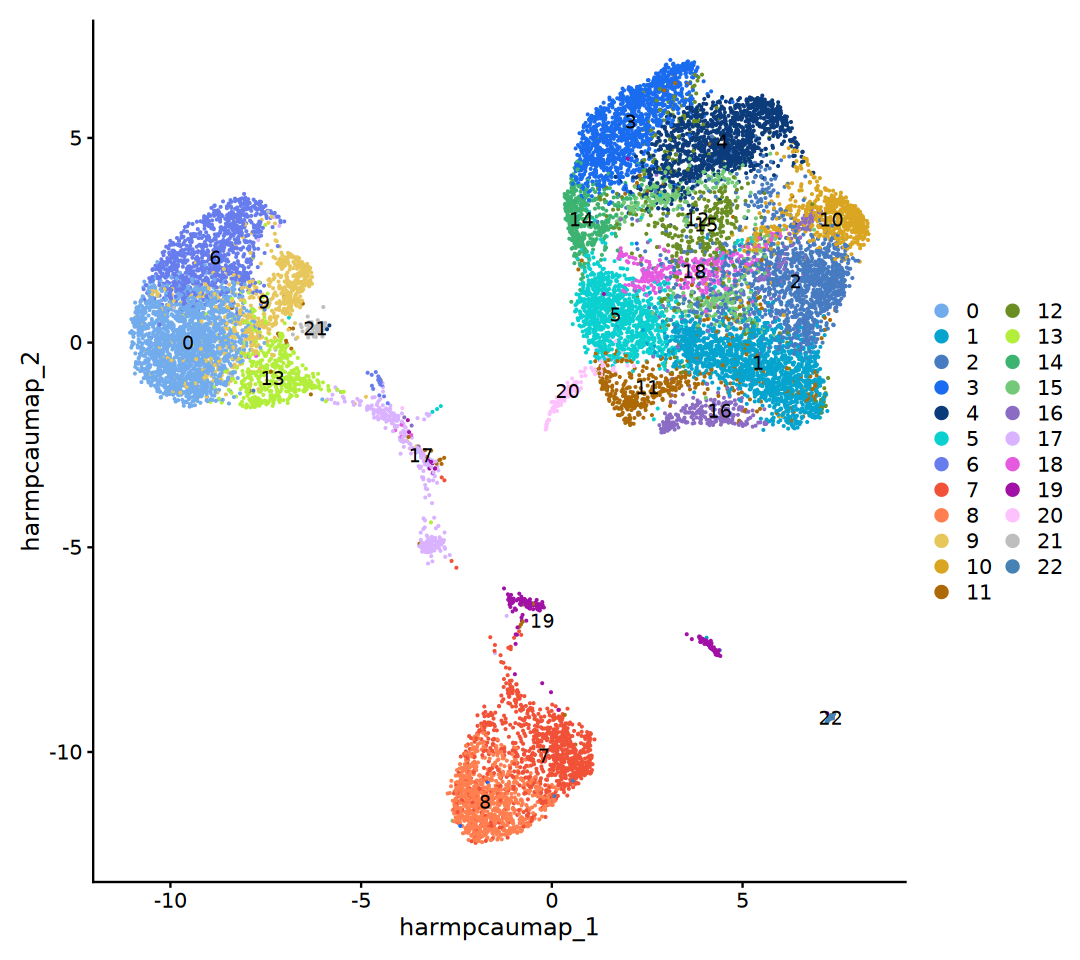

In [23]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", cols = colors, label = TRUE)

In [26]:
sobj$cond.day  <- case_when(
  grepl("ZBC1", sobj$SNG.BEST.GUESS) ~ "control.day.0",
  grepl("ZBC2", sobj$SNG.BEST.GUESS) ~ "control.day.4",
  grepl("ZBC3", sobj$SNG.BEST.GUESS) ~ "control.day.7",
  grepl("ZBl1", sobj$SNG.BEST.GUESS) ~ "IPF.day.0",
  grepl("ZBl2", sobj$SNG.BEST.GUESS) ~ "IPF.day.7",
  grepl("ZBl3", sobj$SNG.BEST.GUESS) ~ "IPF.day.4",
  TRUE ~ NA_character_ 
  ) # Default case if no match is found

In [27]:
# Assuming sobj is your Seurat object
sobj$Day <- case_when(
  grepl("ZBC1", sobj$SNG.BEST.GUESS) ~ "Day.0",
  grepl("ZBC2", sobj$SNG.BEST.GUESS) ~ "Day.4",
  grepl("ZBC3", sobj$SNG.BEST.GUESS) ~ "Day.7",
  grepl("ZBl1", sobj$SNG.BEST.GUESS) ~ "Day.0",
  grepl("ZBl2", sobj$SNG.BEST.GUESS) ~ "Day.7",
  grepl("ZBl3", sobj$SNG.BEST.GUESS) ~ "Day.4",
  TRUE ~ NA_character_  # Default case if no match is found
)

In [28]:
sobj$condition  <- case_when(
  grepl("ZBC1", sobj$SNG.BEST.GUESS) ~ "control",
  grepl("ZBC2", sobj$SNG.BEST.GUESS) ~ "control",
  grepl("ZBC3", sobj$SNG.BEST.GUESS) ~ "control",
  grepl("ZBl1", sobj$SNG.BEST.GUESS) ~ "IPF",
  grepl("ZBl2", sobj$SNG.BEST.GUESS) ~ "IPF",
  grepl("ZBl3", sobj$SNG.BEST.GUESS) ~ "IPF",
  TRUE ~ NA_character_  # Default case if no match is found
)

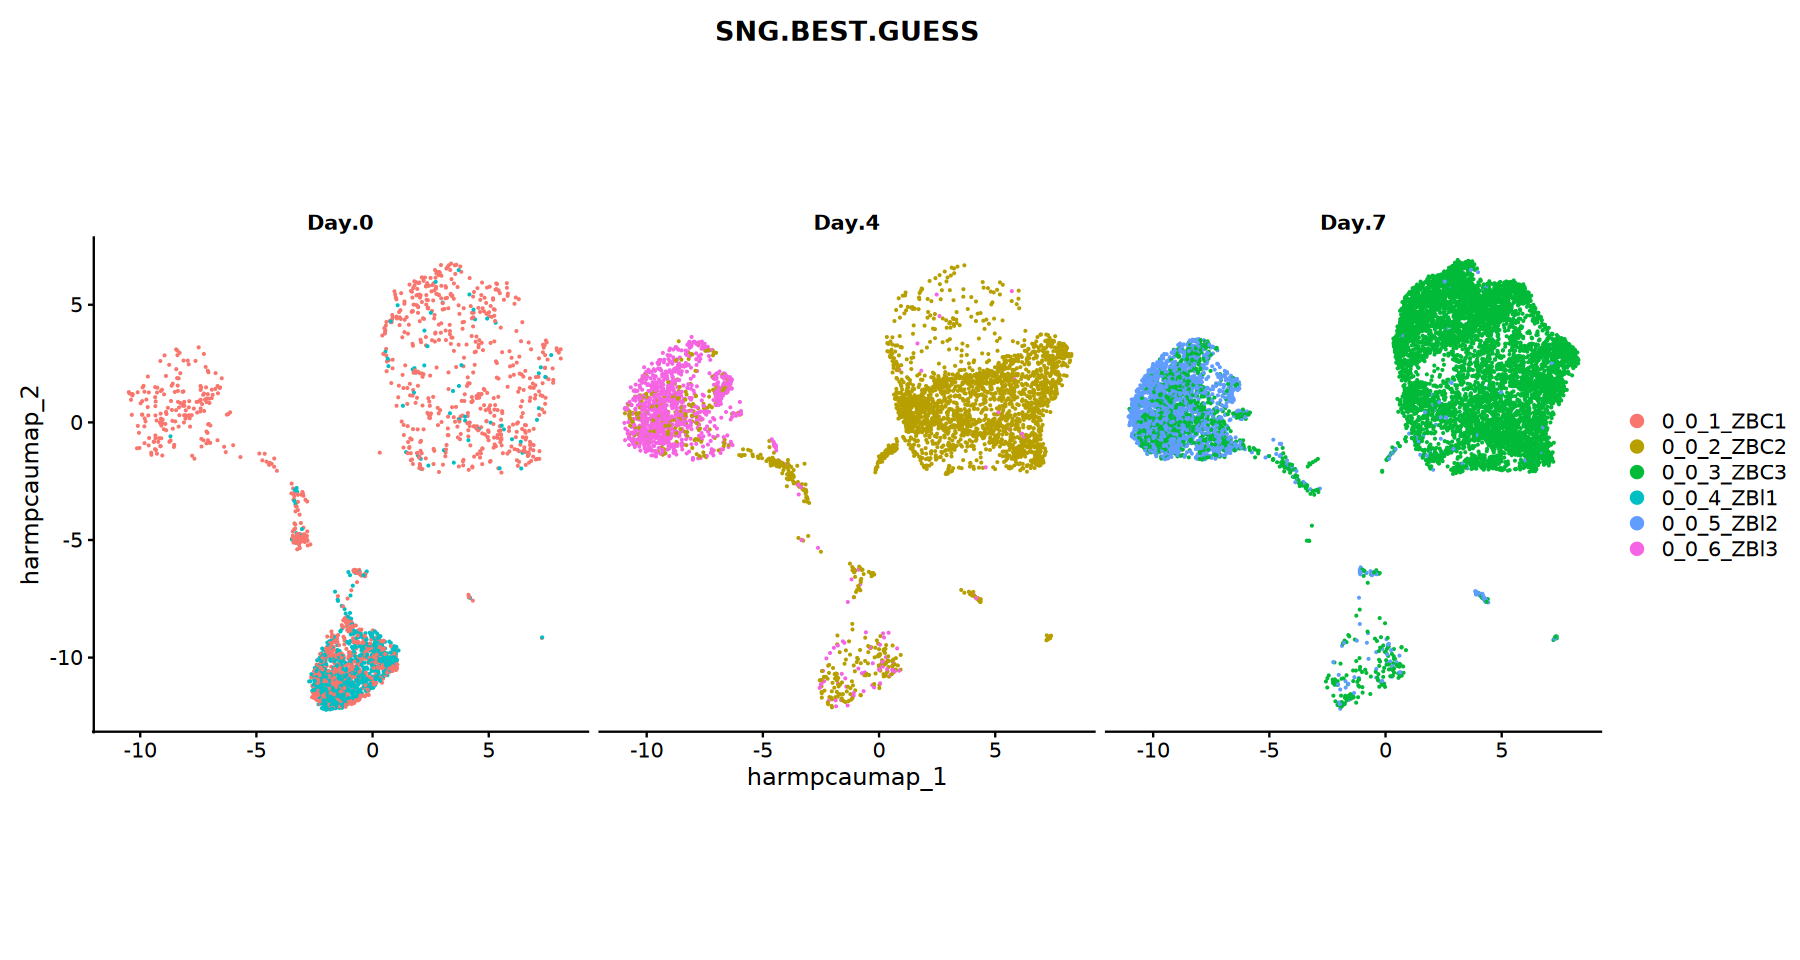

In [29]:
options(repr.plot.width=15, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "SNG.BEST.GUESS", split.by = "Day", ncol = 3) & theme(aspect.ratio = 1)

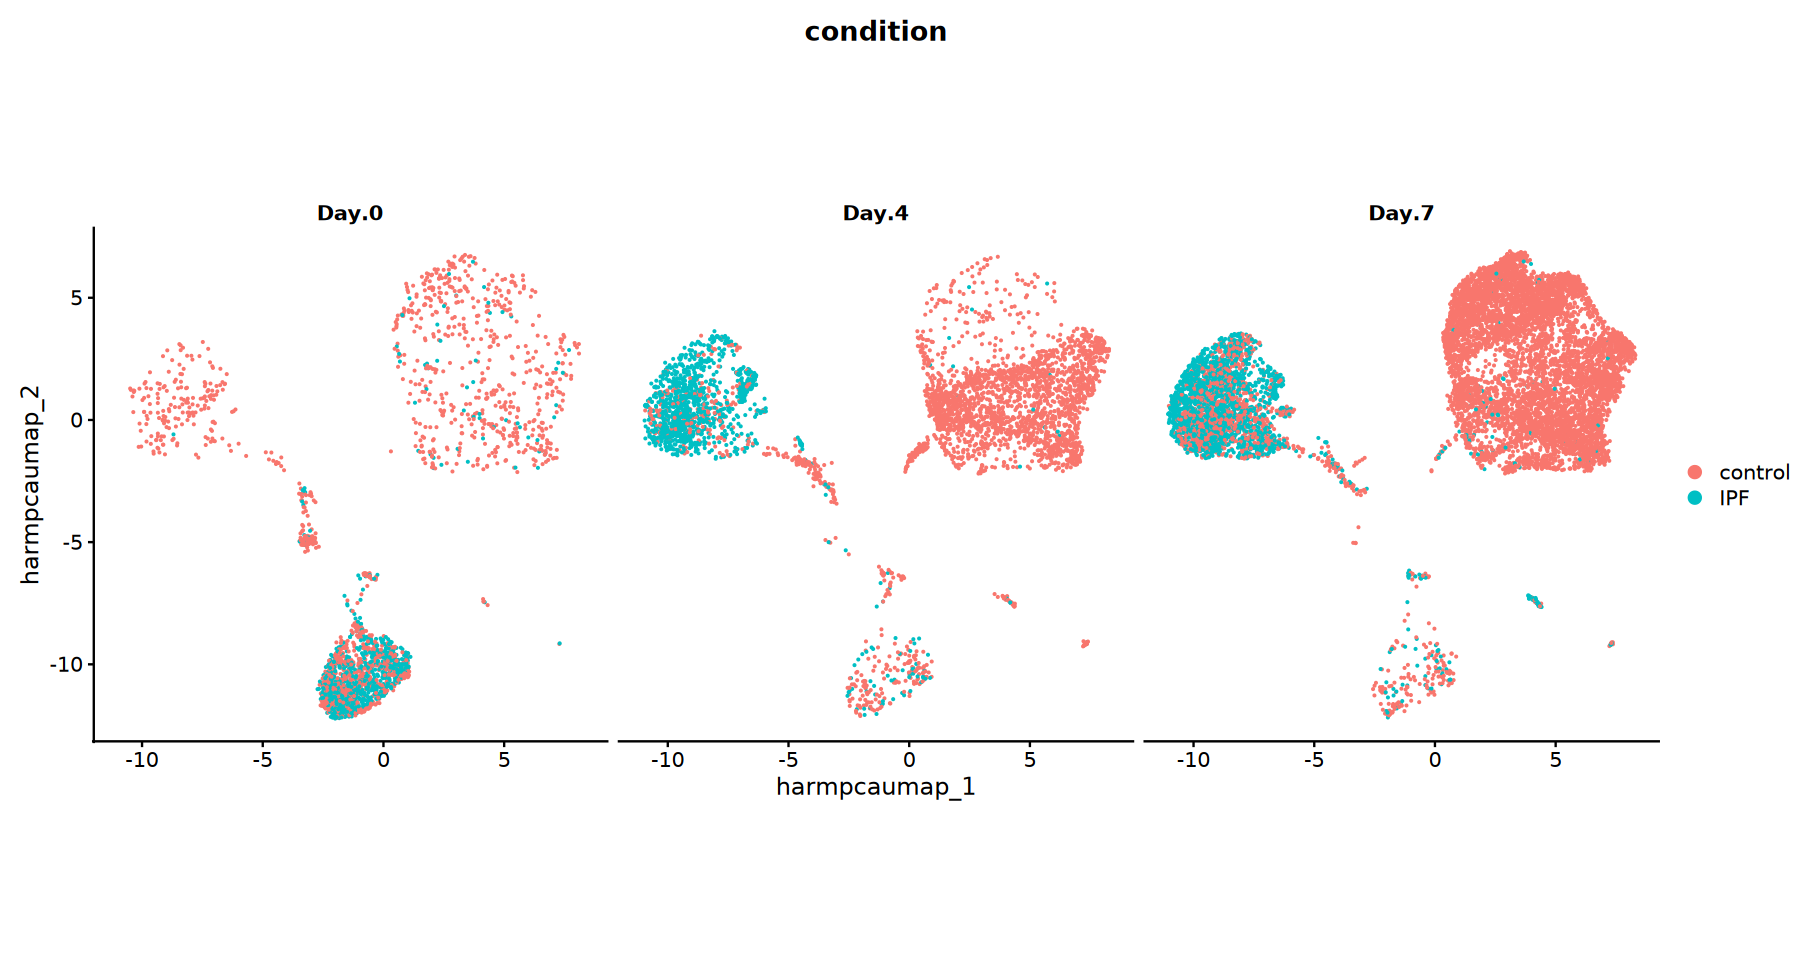

In [30]:
options(repr.plot.width=15, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "condition", split.by = "Day", ncol = 3) & theme(aspect.ratio = 1)

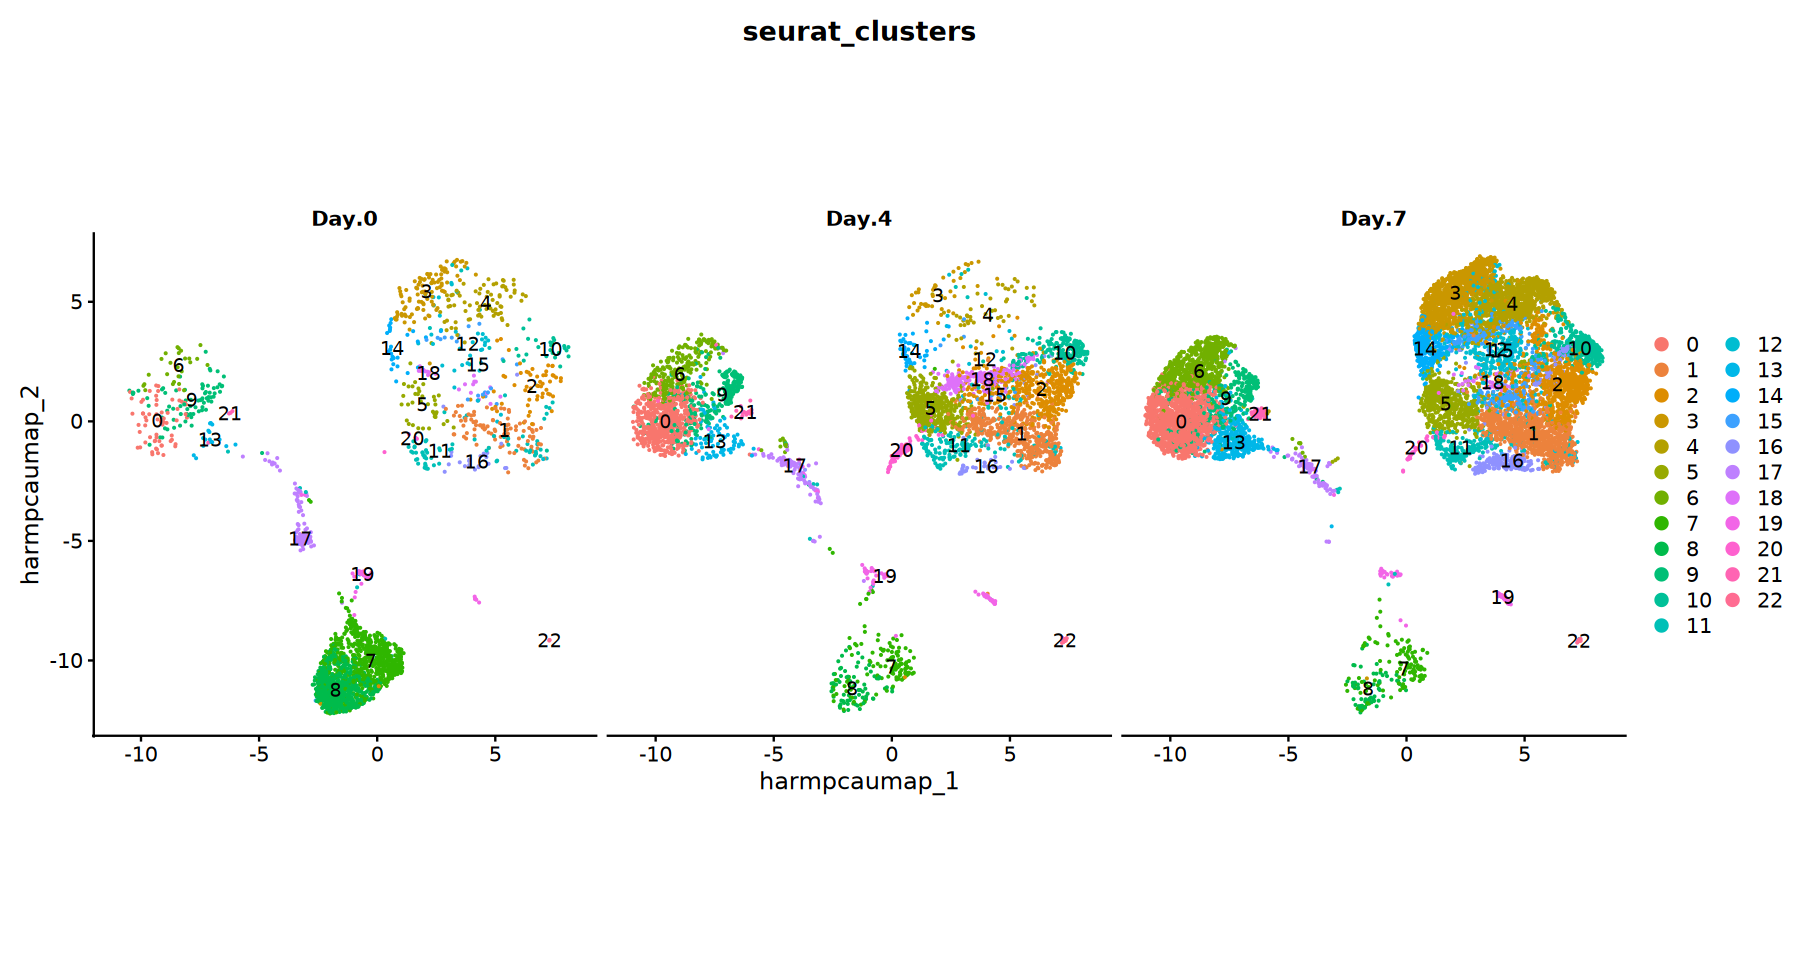

In [32]:
options(repr.plot.width=15, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "seurat_clusters", split.by = "Day", ncol = 3, label = TRUE) & theme(aspect.ratio = 1)

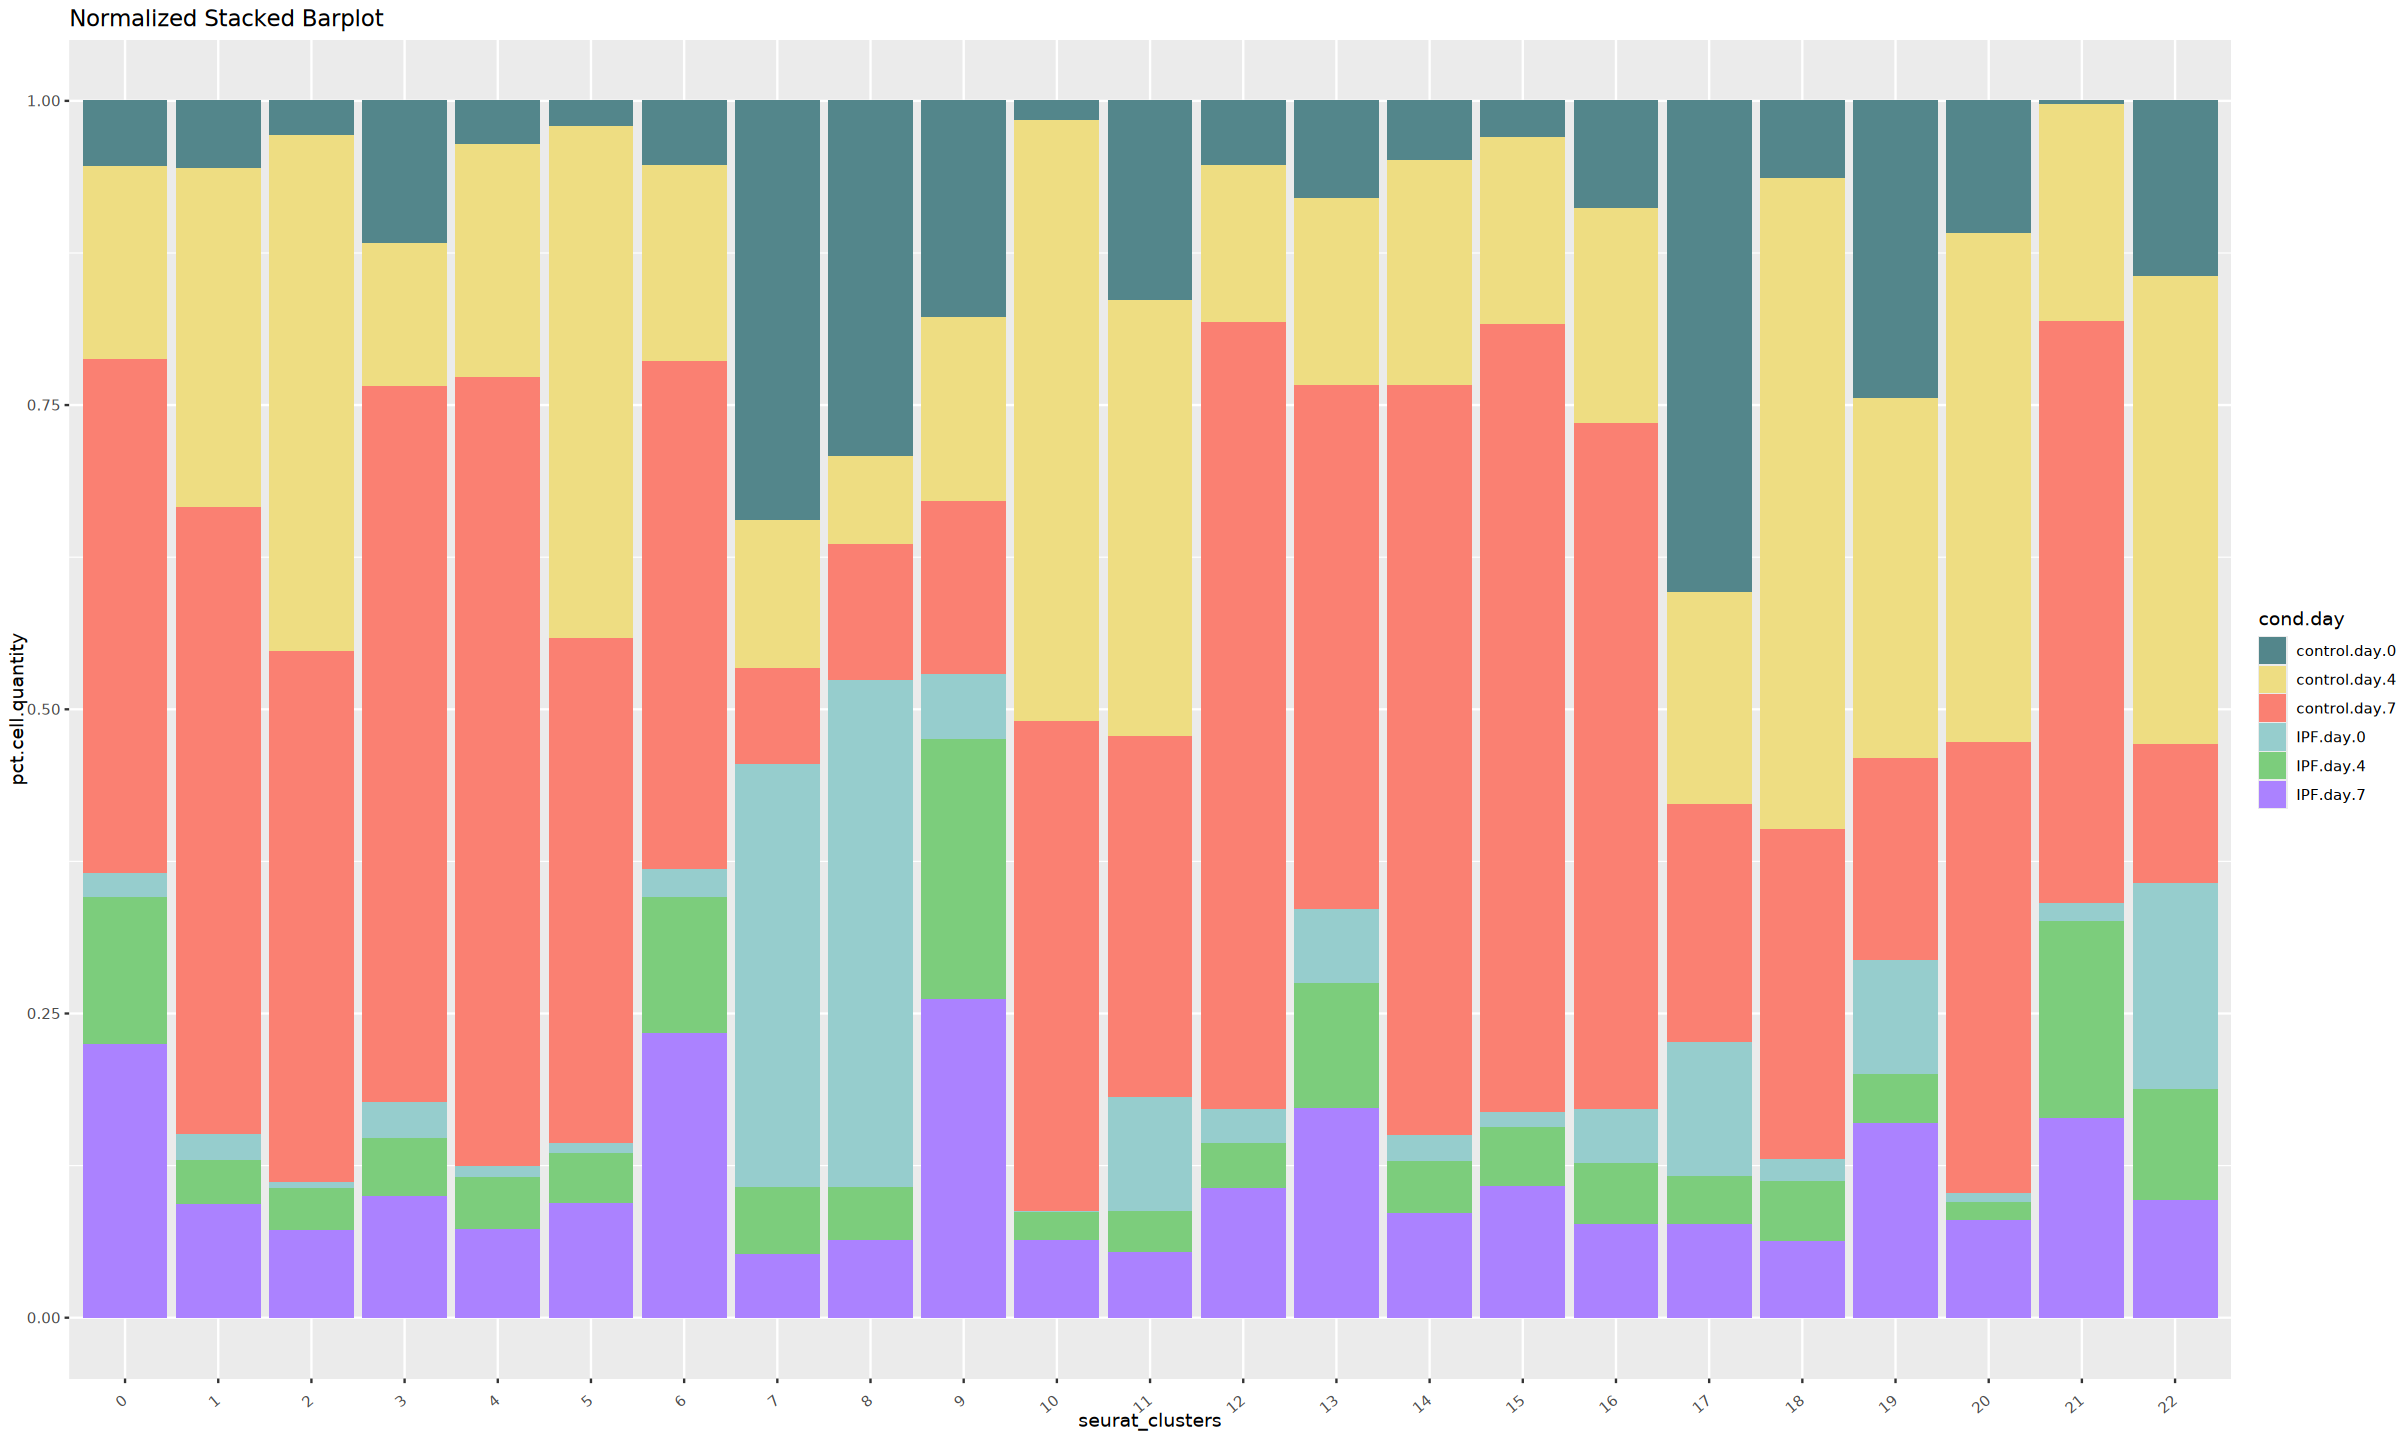

In [46]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "nFeature_RNA", xlab = "seurat_clusters", stack.by = "cond.day", rand.cols = FALSE)

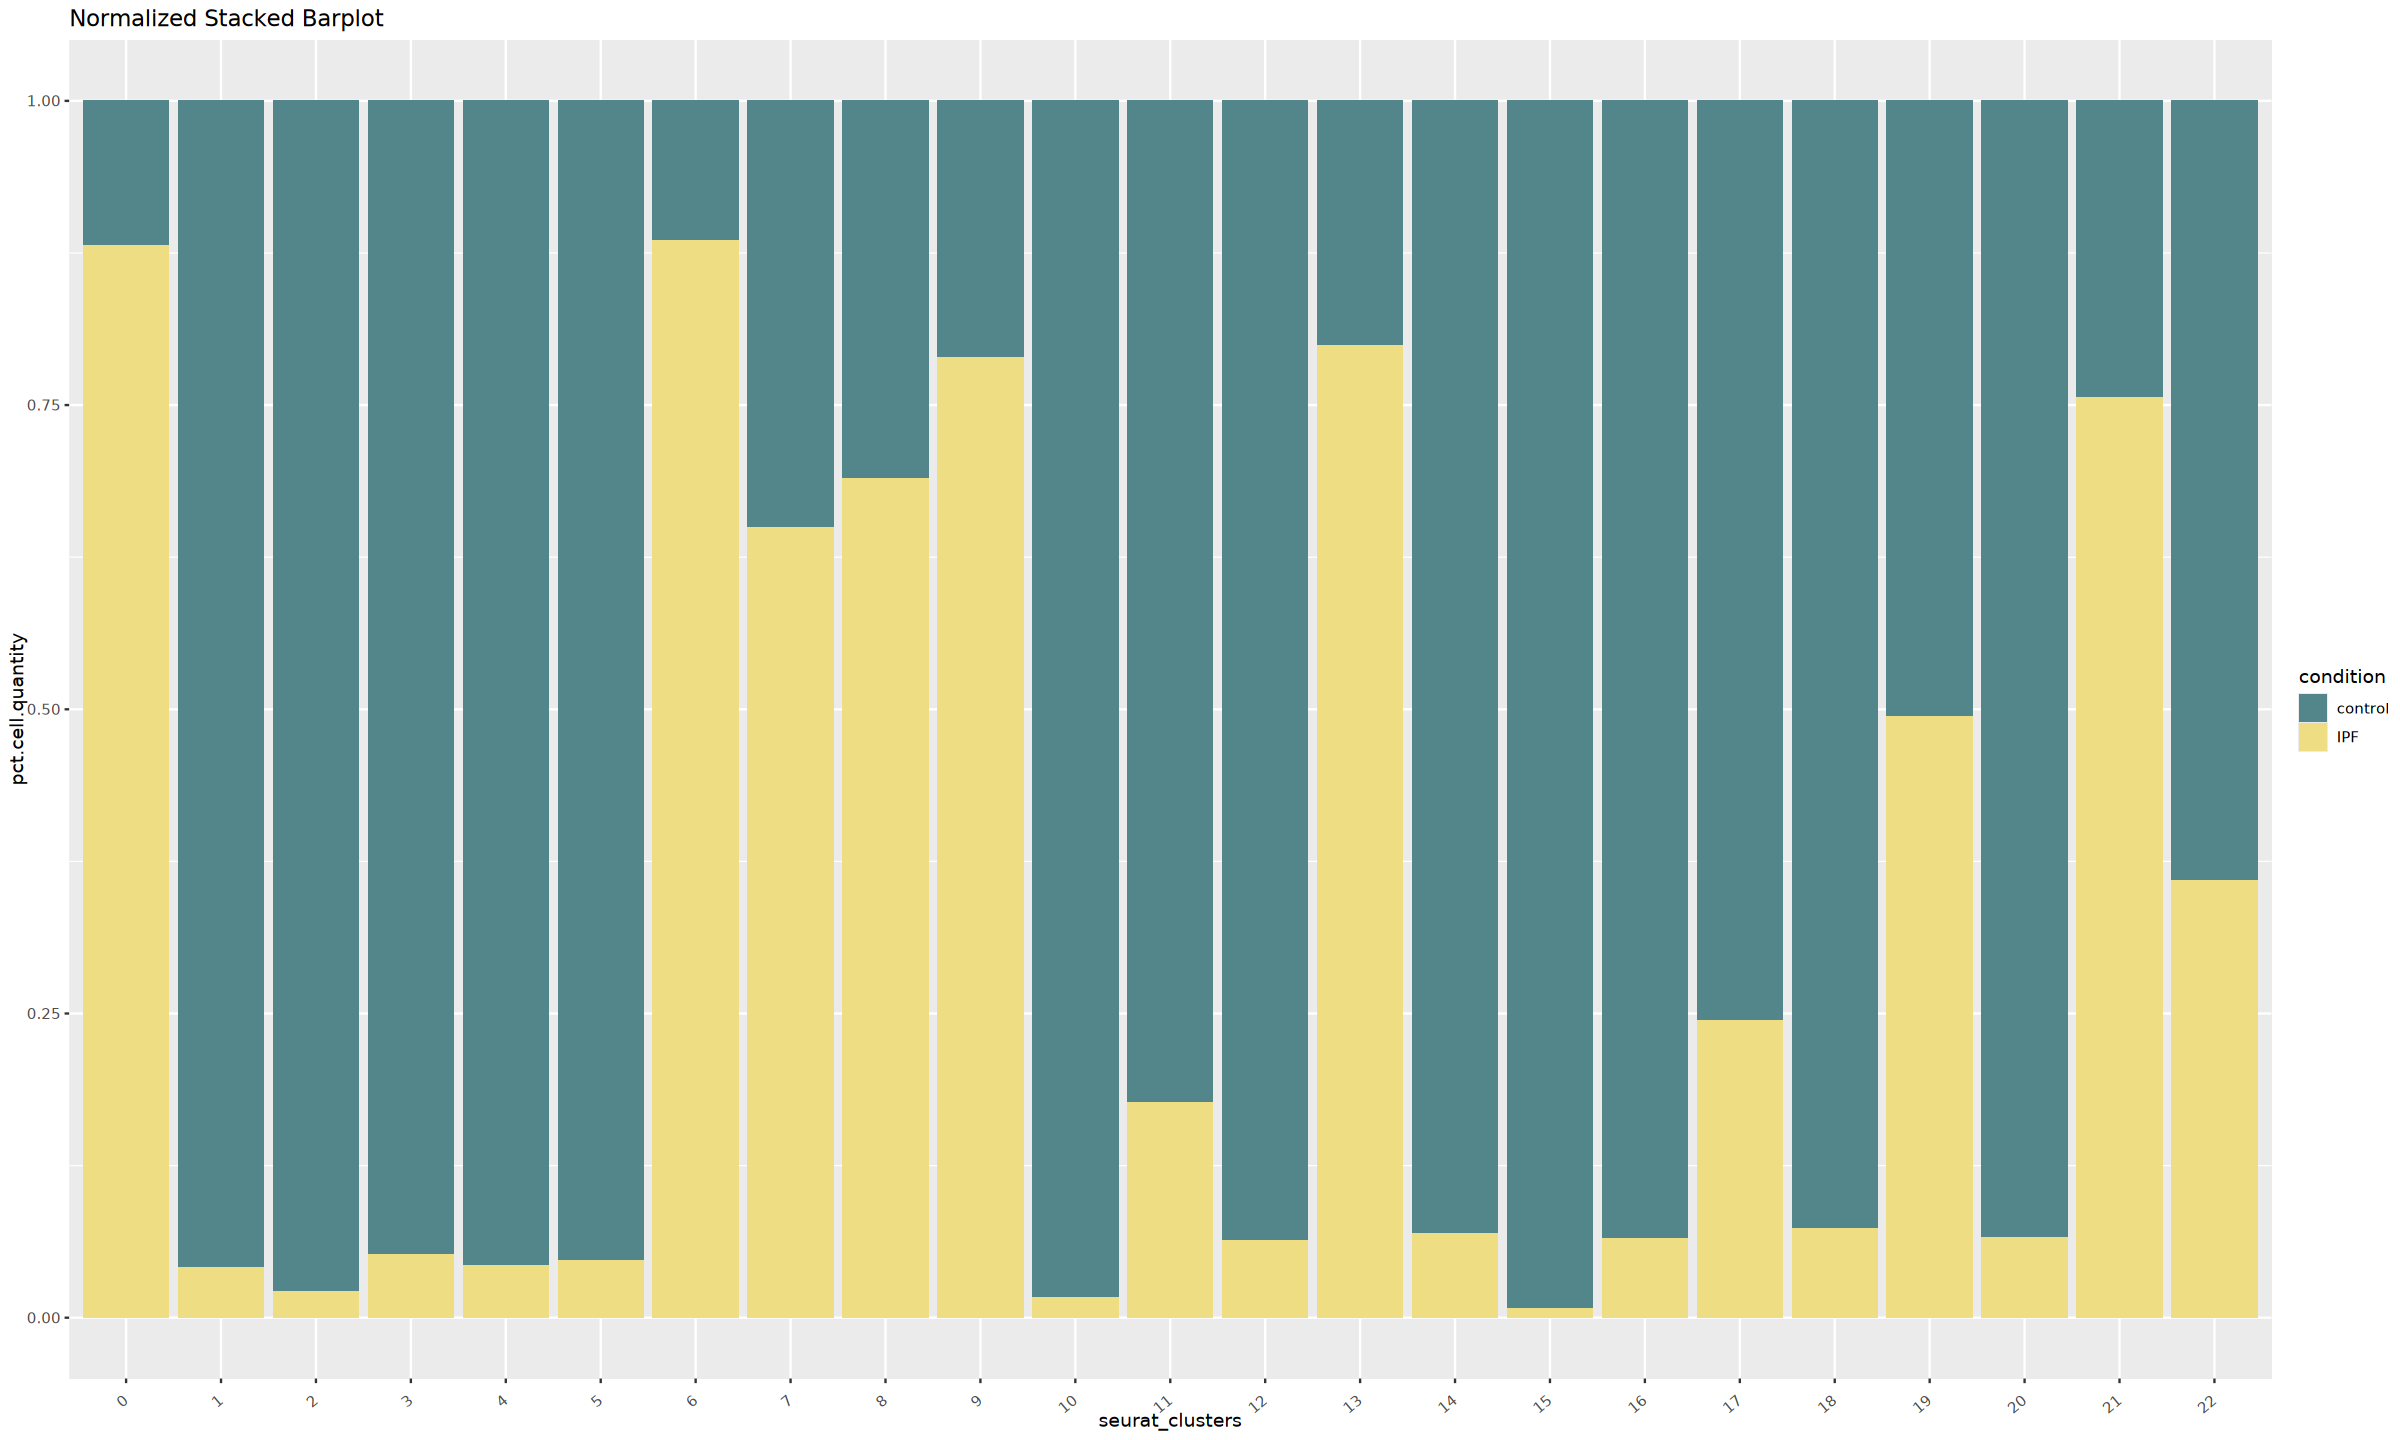

In [33]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "SNG.BEST.GUESS", xlab = "seurat_clusters", stack.by = "condition", rand.cols = FALSE)

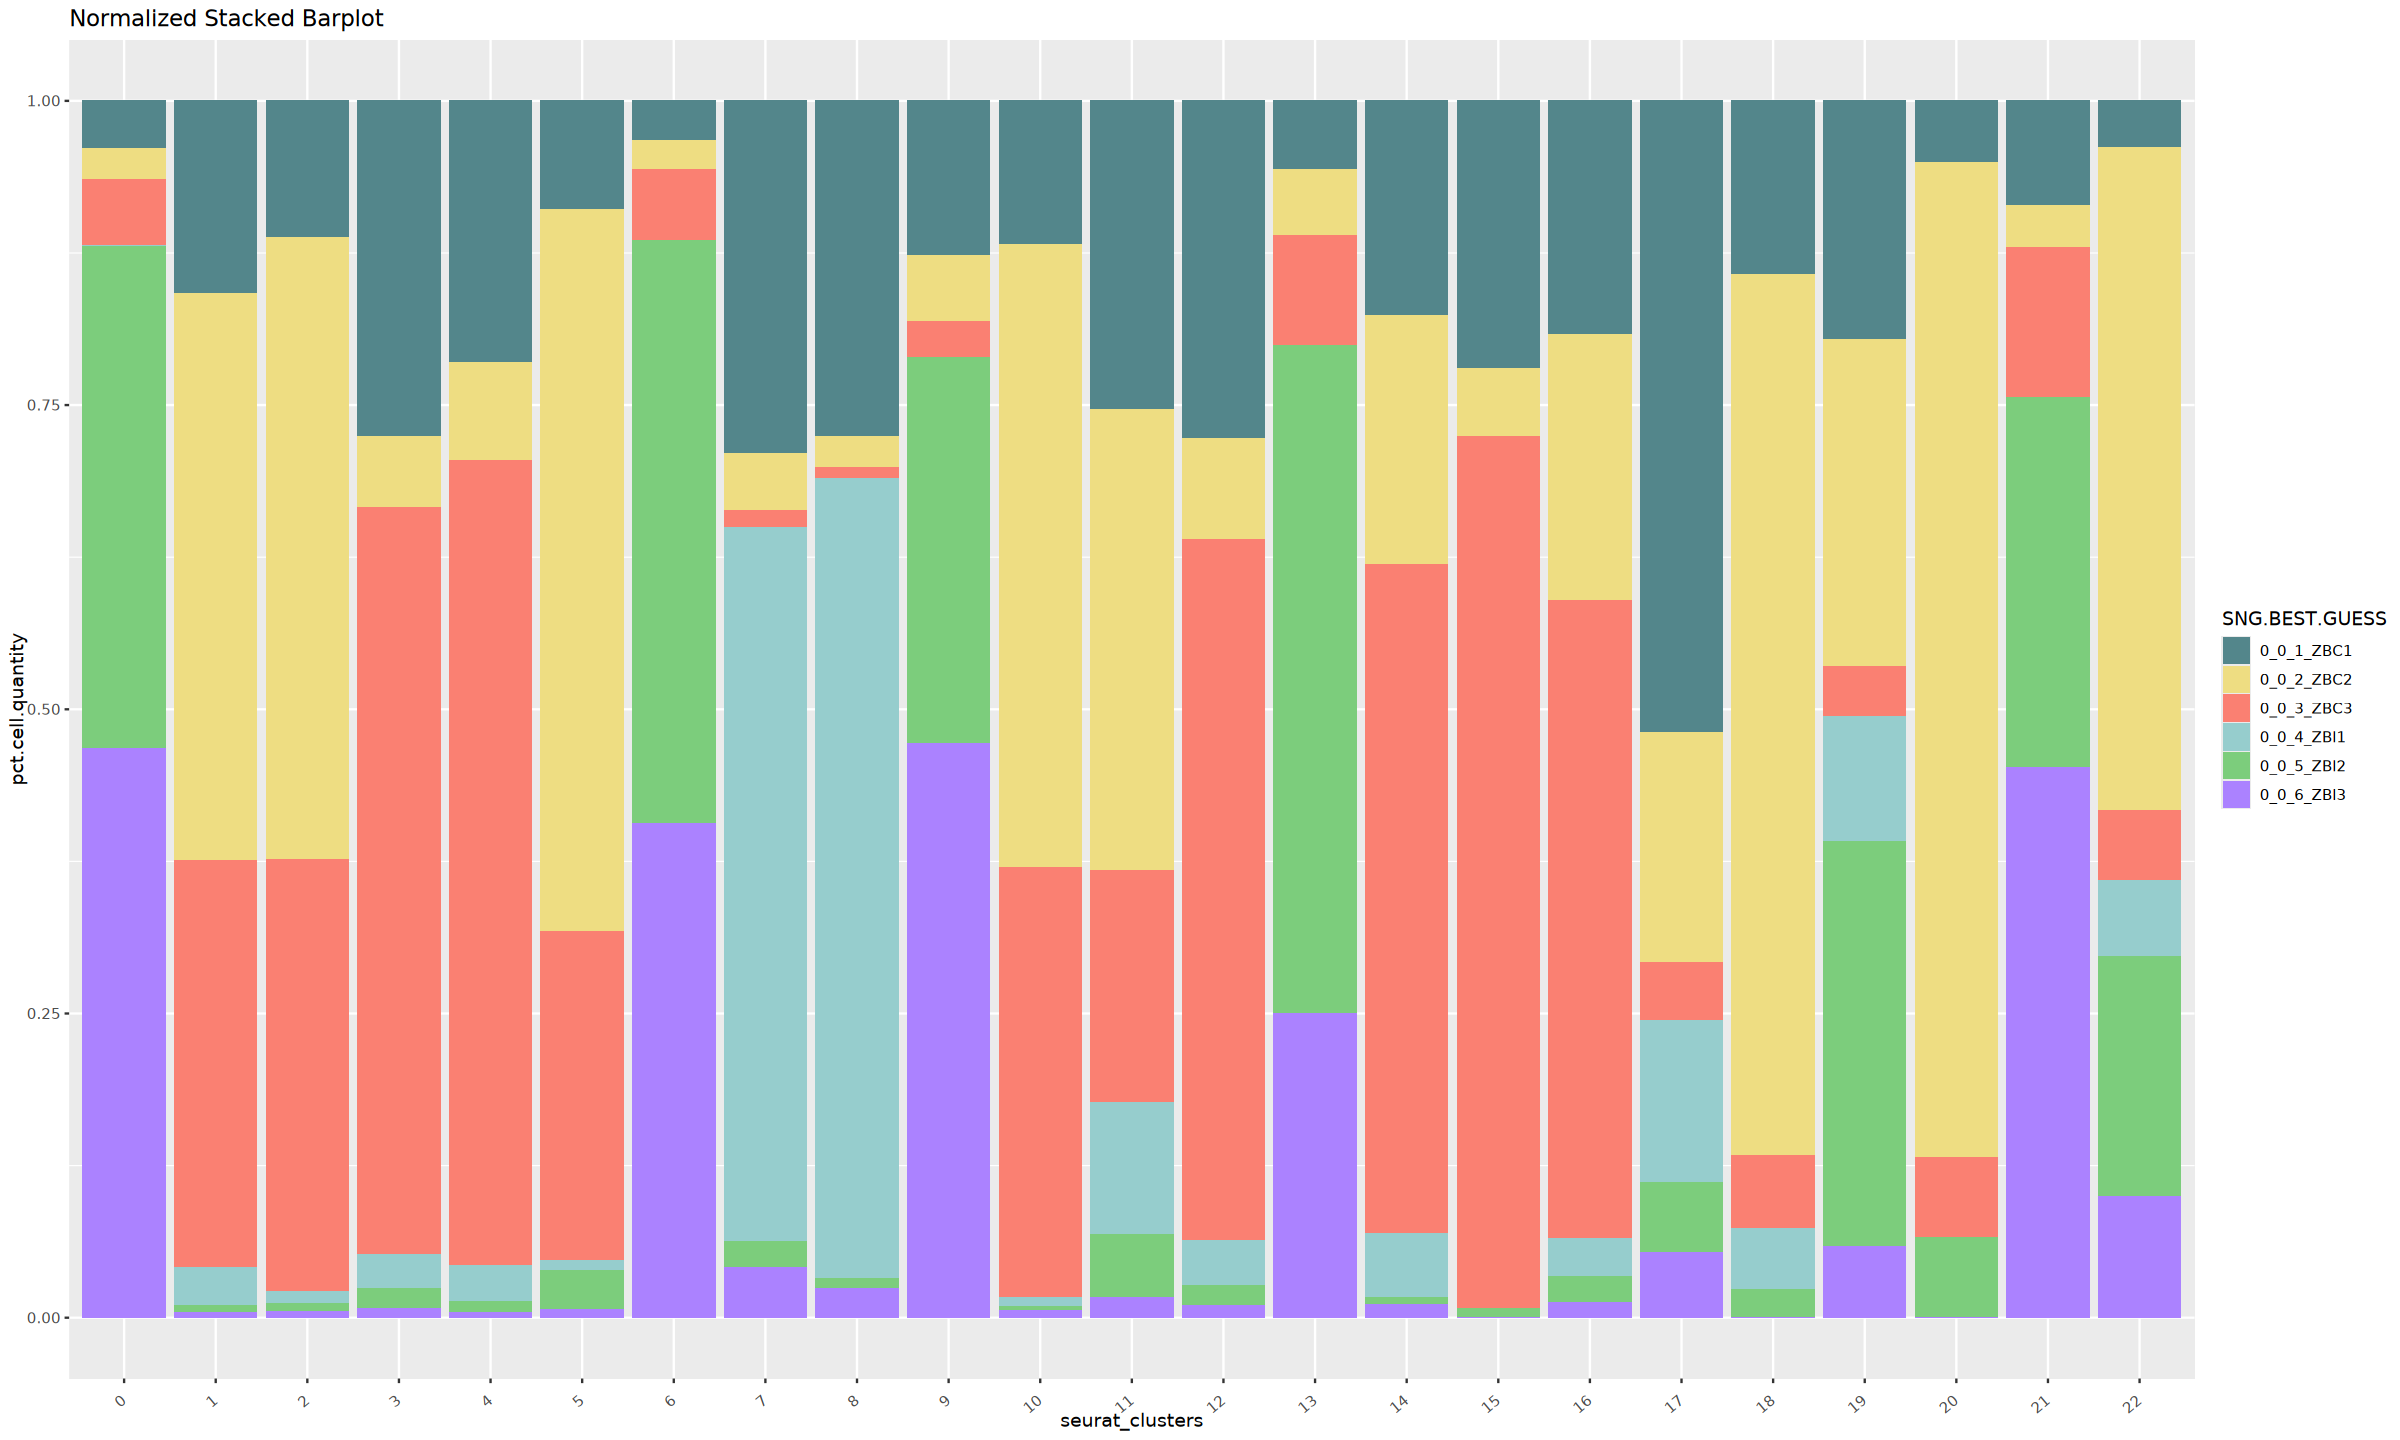

In [34]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "SNG.BEST.GUESS", xlab = "seurat_clusters", stack.by = "SNG.BEST.GUESS", rand.cols = FALSE)

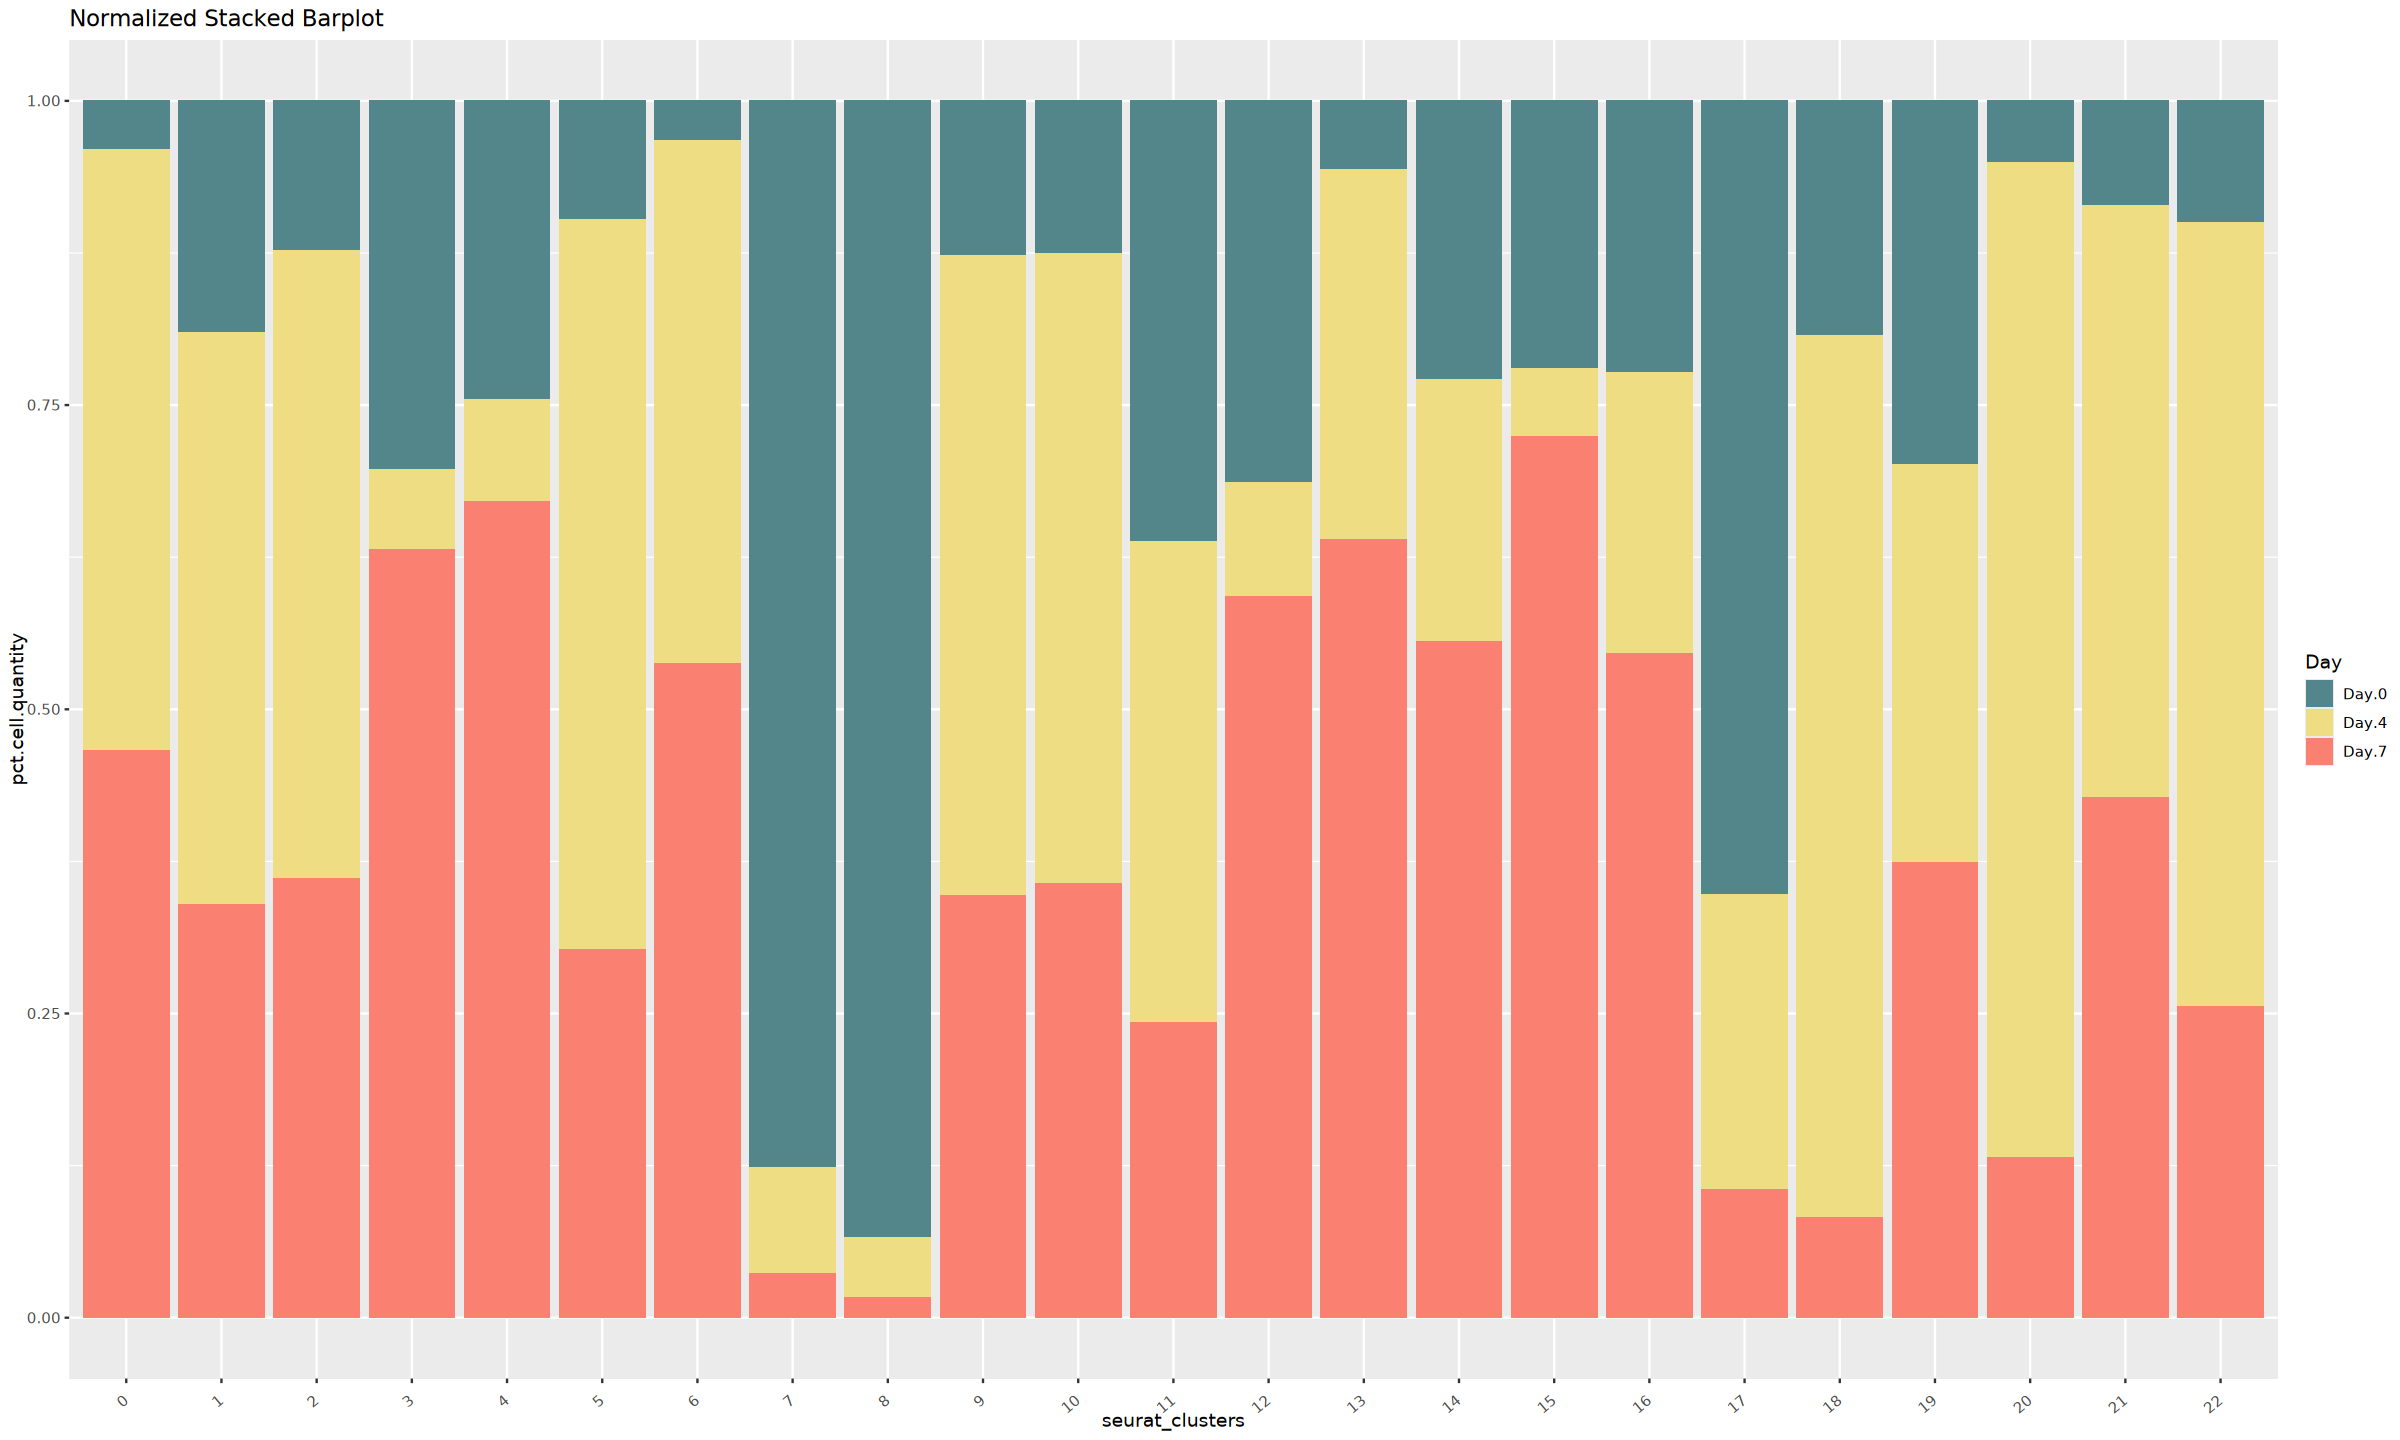

In [47]:
options(repr.plot.width=20, repr.plot.height=12)
norm_cellquant_bplot2.0(sobj, dset.col = "SNG.BEST.GUESS", xlab = "seurat_clusters", stack.by = "Day", rand.cols = FALSE)

In [38]:
colors_24 <- c(
  "red", "blue", "green", "orange", "purple", "brown", "pink", "yellow", "cyan", "magenta",
  "lightblue", "lightgreen", "lightpink", "darkred", "darkblue", "darkgreen", "darkorange", "darkviolet",
  "lightyellow", "lightcyan", "lightgrey", "darkgrey", "beige", "indianred", "gold"
)

In [45]:
table(sobj$condition)


control     IPF 
  12395    4161 

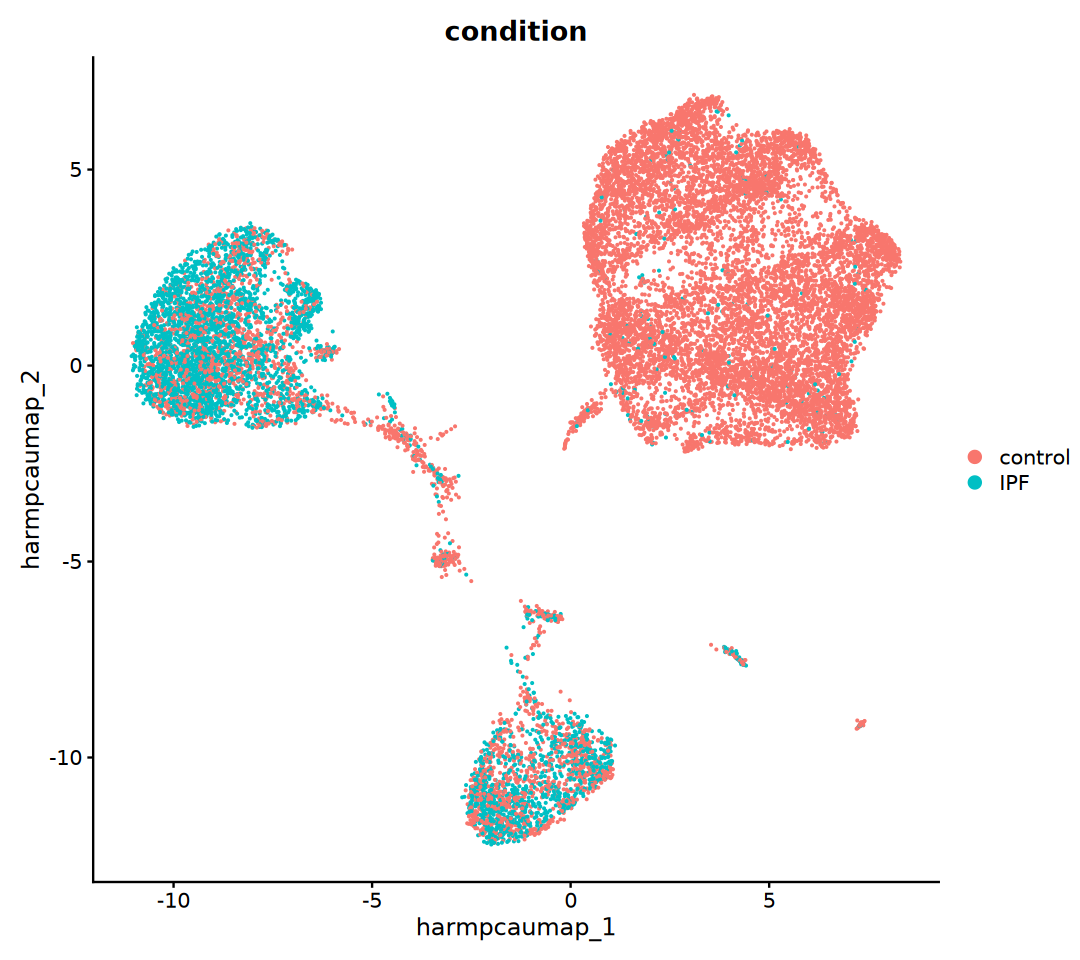

In [41]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "condition")

In [49]:
table(sobj$cond.day)


control.day.0 control.day.4 control.day.7     IPF.day.0     IPF.day.4 
         1529          2878          7988           937          1164 
    IPF.day.7 
         2060 

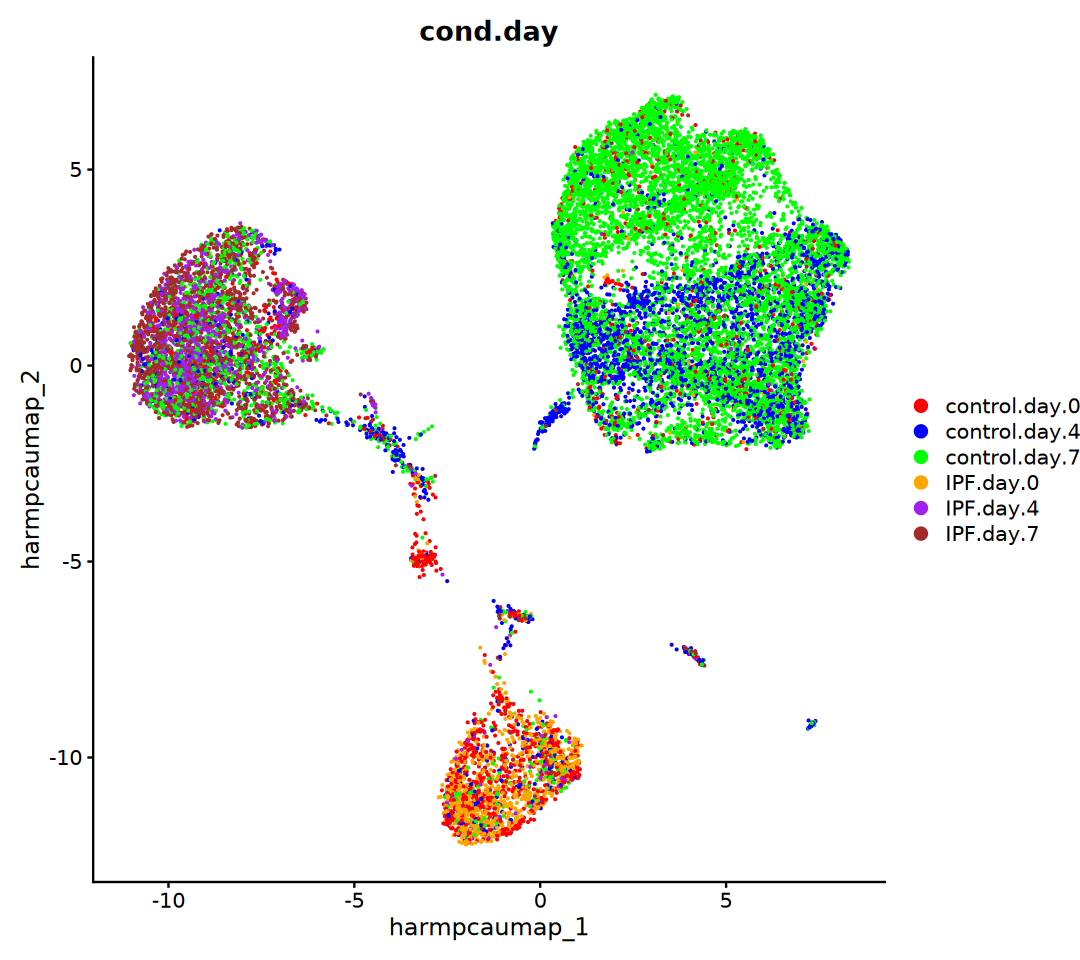

In [43]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "cond.day", cols = colors_24)

In [48]:
table(sobj$Day)


Day.0 Day.4 Day.7 
 2466  4042 10048 

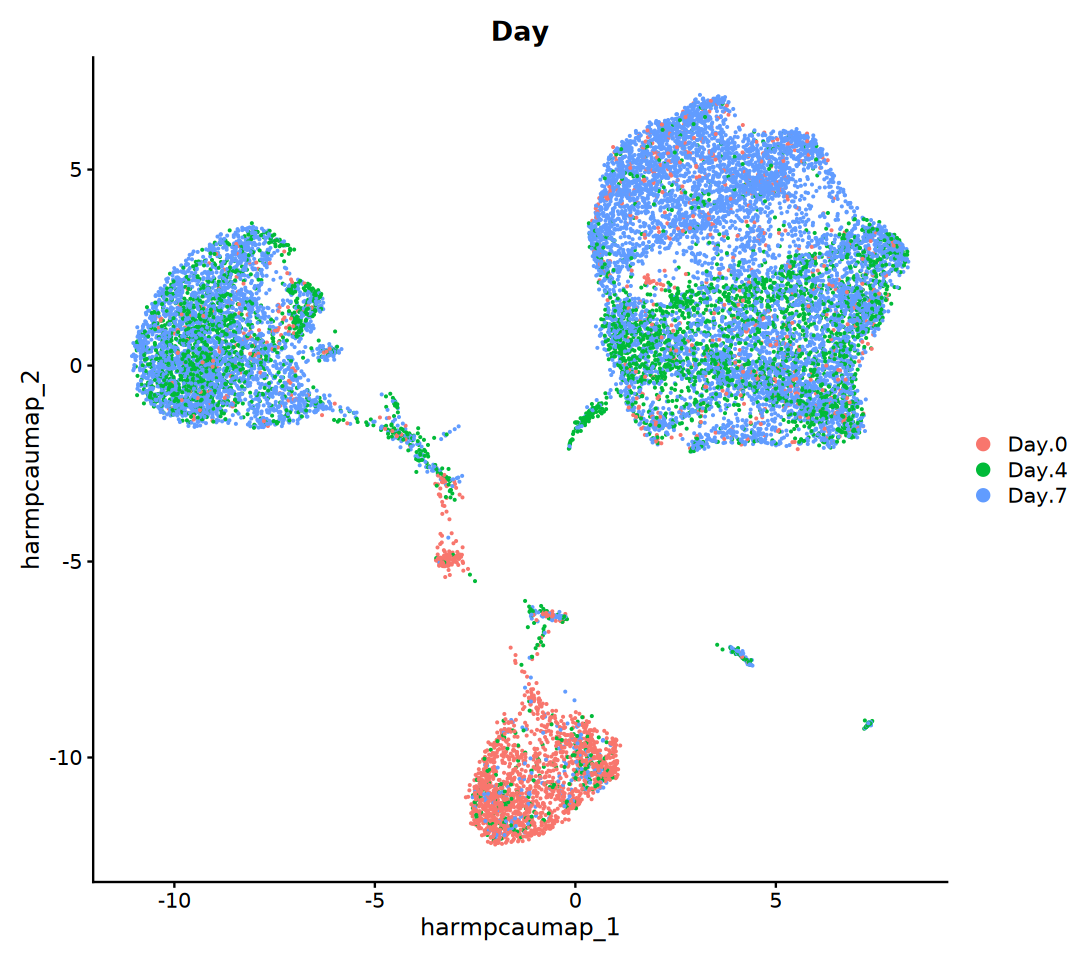

In [44]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "Day")

In [51]:
table(sobj$SNG.BEST.GUESS)


0_0_1_ZBC1 0_0_2_ZBC2 0_0_3_ZBC3 0_0_4_ZBl1 0_0_5_ZBl2 0_0_6_ZBl3 
      1529       2878       7988        937       2060       1164 

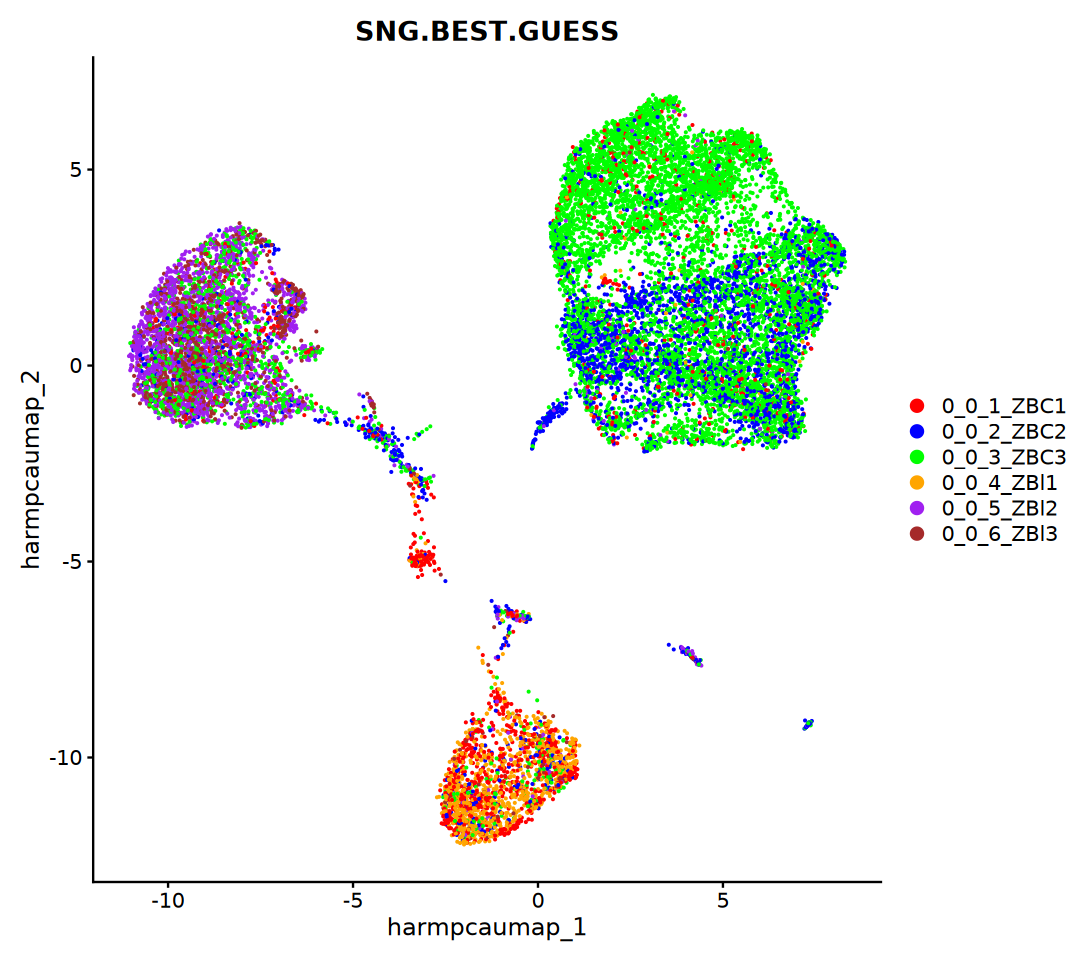

In [50]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(sobj, reduction = "harm.pca.umap", group.by = "SNG.BEST.GUESS", cols = colors_24)

In [52]:
# Load required libraries
library(Seurat)
library(Nebulosa)
library(viridis)

# Define cell type markers
cell_markers <- list(
  AT2 = c("SFTPC", "SFTPB", "ABCA3", "LAMP3", "ETV5", "FGFR2"),
  Transitional = c("KRT8", "CLDN4", "KRT19", "SFN", "LGALS3"),
  AT1 = c("AQP5", "PDPN", "AGER", "CAV1"),
  Aberrant_basaloid = c("KRT17", "TP63", "CDH2"),
  Basal = c("KRT5", "KRT14", "NGFR"),#, "IGTA6"),
  Club = c("SCGB1A1", "SCGB3A2", "CLDN10"),
  Ciliated = c("FOXJ1", "ATAT1", "RSPH1"),
  Goblet = c("MUC5B", "MUC5AC")
)

# Number of unique cell types
n_celltypes <- length(unique(sobj$seurat_clusters))

# Dynamic dimensions for DotPlots
dotplot_width <- min(50, n_celltypes / 1.5)  # Max width of 50 inches
dotplot_height <- min(50, n_celltypes / 1.5)  # Max height of 50 inches

# Dynamic dimensions for Feature Plots
featureplot_width <- min(50, n_celltypes / 1)  # Max width of 50 inches
featureplot_height <- min(50, n_celltypes / 1.5)  # Max height of 50 inches

# Base output directory
base_dir <- "/tscc/projects/ps-epigen/users/a2jorgensen/sandbox/250225_humanAT2_organoids/data/Clustering/JB_1466.batchcorr.donor/"

# Loop through each cell type and generate plots
for (cell_type in names(cell_markers)) {
  # Create directory for the cell type if it doesn't exist
  output_dir <- file.path(base_dir, cell_type)
  if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
  }
  
  # Define marker set
  markers <- cell_markers[[cell_type]]

  # Generate and save DotPlot
  dotplot_path <- file.path(output_dir, paste0("dotplot_", cell_type, ".pdf"))
  pdf(dotplot_path, width = dotplot_width, height = dotplot_height)
  print(
    DotPlot(object = sobj, features = markers, assay = "SCT", group.by = "seurat_clusters", dot.scale = 20, scale = TRUE) +
      scale_color_viridis(option = "viridis") +
      theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 25, face = "bold"),
            axis.text.y = element_text(size = 25, face = "bold"))
  )
  dev.off()
  
  # Generate and save Nebulosa feature plot
  nebulosa_path <- file.path(output_dir, paste0("nebulosa_feature_plot_", cell_type, ".pdf"))
  pdf(nebulosa_path, width = featureplot_width, height = featureplot_height)
  print(plot_density(sobj, features = markers, joint = TRUE))
  dev.off()
}


Loading required package: viridisLite

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
